# Readme
This notebook is used to prepare the data from which all the results are then computed. The main reason is that the original data file is too large to be shared, and also the computation of the performance curves is a bit time consuming.

In [1]:
#import autosklearn.classification
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import openml
import datetime

import scipy as sp
import scipy.stats
import numpy as np
import pandas as pd
import itertools as it
from tqdm.notebook import tqdm
import ast
import json
import pickle
from os import path

import matplotlib.pyplot as plt


OPTIMIZERS = ["rf", "random", "auto-sklearn", "gama", "naive", "semi-naive"]
OPTIMIZER_COLORS = {"rf": "C5", "random": "C6", "auto-sklearn": "C0", "gama": "C1", "naive": "C2", "semi-naive": "C3"}
OPTIMIZER_NAMES = {"rf": "Random Forest", "random": "Random Search", "auto-sklearn": "auto-sklearn", "gama": "GAMA", "naive": "naive", "semi-naive": "quasi-naive"}

In [2]:
dfResults = pd.read_csv("results.csv", delimiter=";")

In [3]:
dfResults = dfResults[(dfResults["time_end"].notna()) & (dfResults["exception"].isna()) & (dfResults["metric"].notna())]
dfResults = dfResults[(dfResults["algorithm"].isin(OPTIMIZERS))]
dfResults

,experiment_id,openmlid,seed,algorithm,timeout_total,timeout_evaluation,cpus,memory_max,time_created,host,executor,time_started,chosenmodel,errorrate,metric,onlinedata,exception,time_end
0,1,1485,0,rf,85000,1200,2,24000,2021-12-04 01:08:43,node09-010,oculus-9857443-159,2021-12-04 01:19:30,RandomForestClassifier()\n,0.303846,0.600788,[]\n,NaN,2021-12-04 01:19:49
1,2,1485,0,random,85000,1200,2,24000,2021-12-04 01:08:43,node09-010,oculus-9857443-160,2021-12-04 01:19:31,"Pipeline(steps=[('data-pre-processor', Standar...",0.142308,0.373946,"[[1.9233262538909912, ""Pipeline(steps=[('data-...",NaN,2021-12-05 00:57:19
2,3,1590,0,rf,85000,1200,2,24000,2021-12-04 01:08:43,node08-010,oculus-9857443-92,2021-12-04 01:19:30,RandomForestClassifier()\n,0.176459,0.570204,[]\n,NaN,2021-12-04 01:20:21
3,4,1485,0,auto-sklearn,85000,1200,2,24000,2021-12-04 01:08:43,node08-032,oculus-9857443-119,2021-12-04 01:19:30,"[(1.000000, SimpleClassificationPipeline({'bal...",0.111538,0.288015,"{""mean_test_score"": [""0.6106343839667802"", ""1....",NaN,2021-12-05 00:57:01
4,5,1590,0,random,85000,1200,2,24000,2021-12-04 01:08:43,node03-046,oculus-9886851-442,2021-12-19 01:57:25,"Pipeline(steps=[('data-pre-processor', Normali...",0.170317,0.358099,"[[0.09204339981079102, ""Pipeline(steps=[('data...",NaN,2021-12-20 01:38:26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4013,4014,31,7,semi-naive,85000,1200,2,24000,2021-12-09 12:55:08,node02-016,oculus-9886851-404,2021-12-20 22:04:51,"Pipeline(steps=[('data-pre-processor', Varianc...",0.130000,0.417230,"[[1.9434823989868164, ""Pipeline(steps=[('class...",NaN,2021-12-21 21:41:39
4014,4015,40975,8,semi-naive,85000,1200,2,24000,2021-12-09 12:55:08,node10-003,oculus-9886851-391,2021-12-20 12:49:38,"Pipeline(steps=[('data-pre-processor', Varianc...",0.000000,0.014152,"[[0.1249234676361084, ""Pipeline(steps=[('class...",NaN,2021-12-21 12:26:29
4015,4016,31,8,naive,85000,1200,2,24000,2021-12-09 12:55:08,node05-035,oculus-9886851-371,2021-12-20 21:27:45,"Pipeline(steps=[('data-pre-processor', Varianc...",0.250000,0.517943,"[[0.01375126838684082, ""Pipeline(steps=[('clas...",NaN,2021-12-21 21:04:37
4017,4018,31,8,semi-naive,85000,1200,2,24000,2021-12-09 12:55:08,node09-018,oculus-9886851-156,2021-12-20 10:18:33,"Pipeline(steps=[('data-pre-processor', Varianc...",0.310000,0.623437,"[[1.9768009185791016, ""Pipeline(steps=[('class...",NaN,2021-12-21 09:55:23


In [4]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier, HistGradientBoostingClassifier, RandomForestClassifier

from sklearn.decomposition import FastICA, KernelPCA, PCA
from sklearn.cluster import FeatureAgglomeration
from sklearn.kernel_approximation import RBFSampler, Nystroem
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, Normalizer, PowerTransformer, QuantileTransformer, RobustScaler, StandardScaler
from sklearn.feature_selection import SelectPercentile, GenericUnivariateSelect, VarianceThreshold


def recover_pipeline(pl_as_str):
    if type(pl_as_str) != str:
        raise Exception()
    if pl_as_str[:8] != "Pipeline":
        raise Exception()
    try:
        return eval(pl_as_str)
    except:
        print(f"COULD NOT PARSE pipeline {pl_as_str}")
        return None

In [5]:
from util import *
from singularity.experimentutils import *

def get_history(dfCase):
    if type(dfCase) == pd.Series:
        case = dfCase
    else:
        raise Exception(f"Unknown type {type(dfCase)}")
    return json.loads(case["onlinedata"])

def get_best_pipeline_after_time(dfCase, time):
    relevant_history = [e for e in get_history(dfCase) if not np.isnan(e[2]["neg_log_loss"]) and int(e[0]) <= time]
    if relevant_history:
        best_entry_in_time = relevant_history[np.argmax([e[2]["neg_log_loss"] for e in relevant_history])]
        return recover_pipeline(best_entry_in_time[1])
    else:
        return None


def evaluate_best_pipeline_after_time_on_test_data(dfCase, time):
    if type(dfCase) == pd.core.series.Series:
        case = dfCase
    elif type(dfCase) == pd.DataFrame:
        case = dfCase.iterrows().next()[1]
    else:
        raise Exception(f"Unknown type {type(dfCase)}")
    pl = get_best_pipeline_after_time(case, time)
    if pl is None:
        return np.nan
    
    X, y = get_dataset(int(case["openmlid"]))
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.9, random_state=int(case["seed"]))
    pl.fit(X_train, y_train)
    y_prob = pl.predict_proba(X_test)
    score = sklearn.metrics.log_loss(y_test, y_prob)
    return score

In [6]:
datasets_covered_by_openmlbenchmark = [3, 12, 31, 54, 1067, 1111, 1590, 1596, 1489, 1486, 1468, 1464, 1461, 4135, 40668, 40685, 23512, 40981, 40975, 40984, 40996, 41027, 23517, 41169, 41168, 41166, 41165, 41150, 41159, 41161, 41138, 41142, 41163, 41164, 41143, 41146, 1169, 41167, 41147] # = [openml.tasks.get_task(task_id).get_dataset().id for task_id in openml.study.get_suite(218).tasks]
print(len(datasets_covered_by_openmlbenchmark))
print(datasets_covered_by_openmlbenchmark)

39
[3, 12, 31, 54, 1067, 1111, 1590, 1596, 1489, 1486, 1468, 1464, 1461, 4135, 40668, 40685, 23512, 40981, 40975, 40984, 40996, 41027, 23517, 41169, 41168, 41166, 41165, 41150, 41159, 41161, 41138, 41142, 41163, 41164, 41143, 41146, 1169, 41167, 41147]


In [7]:
datasets = [int(i) for i in pd.unique(dfResults["openmlid"])]
datasets = [i for i in datasets if not i in [188, 1111, 41138, 41147, 41162]]
dfResults = dfResults[dfResults["openmlid"].isin(datasets)]

FILENAME = "metadata.csv"
if not path.exists(FILENAME):
    rows = []
    metrics = {}
    for openmlid in tqdm(datasets):
        dataset = openml.datasets.get_dataset(openmlid)
        
        is_in_automl_benchmark = openmlid in datasets_covered_by_openmlbenchmark
        
        # analyze columns of data
        dfDataset = dataset.get_data()[0]
        types = dfDataset.dtypes
        cnt_normalized = 0
        cnt_zero_mean = 0
        cnt_one_std = 0
        cnt_numerical = 0
        for i, col in enumerate(dfDataset.columns):
            if "float" in str(types[i]) or "int" in str(types[i]):
                cnt_numerical += 1
                vals = dfDataset[col].values
                is_normalized = np.round(min(vals), 3) == 0 and np.round(max(vals), 3) == 1
                is_zero_mean = np.round(np.mean(vals), 3) == 0
                is_one_std = np.round(np.std(vals), 3) == 1
                if is_normalized:
                    cnt_normalized += 1
                if is_zero_mean:
                    cnt_zero_mean += 1
                if is_one_std:
                    cnt_one_std += 1
        if cnt_numerical > 0:
            feature_stats_entries = [str(v) + "\%" for v in np.round(100 * np.array([cnt_normalized / cnt_numerical, cnt_zero_mean / cnt_numerical, cnt_one_std / cnt_numerical]), 0).astype(int)]
        else:
            feature_stats_entries = 3 * ["n/a"]

        row = [openmlid, is_in_automl_benchmark, dataset.name, int(dataset.qualities["NumberOfInstances"]), len(dataset.features) - 1, int(dataset.qualities["NumberOfNumericFeatures"]), int(dataset.qualities["NumberOfClasses"]), str(int(dataset.qualities["MinorityClassPercentage"])) + "\%", str(int(dataset.qualities["MajorityClassPercentage"])) + "\%", str(int(dataset.qualities["PercentageOfMissingValues"])) + "\%"] + feature_stats_entries
        rows.append(row)
    dfDatasets = pd.DataFrame(rows, columns=["openmlid", "in benchmark", "name", "instances", "features", "numeric features", "classes", "min \%", "maj \%", "\% missing", "\% [0,1]", "\% $\mu = 0$", "\% $\sigma = 1$"]).sort_values("openmlid")
    dfDatasets.to_csv(FILENAME, index=False)
    
else:
    dfDatasets = pd.read_csv(FILENAME)
dfDatasets

  0%|          | 0/62 [00:00<?, ?it/s]

,openmlid,in benchmark,name,instances,features,numeric features,classes,min \%,maj \%,\% missing,"\% [0,1]",\% $\mu = 0$,\% $\sigma = 1$
55,3,True,kr-vs-kp,3196,36,0,2,47\%,52\%,0\%,n/a,n/a,n/a
53,12,True,mfeat-factors,2000,216,216,10,10\%,10\%,0\%,0\%,0\%,0\%
54,23,False,cmc,1473,9,2,3,22\%,42\%,0\%,0\%,0\%,0\%
61,31,True,credit-g,1000,20,7,2,30\%,70\%,0\%,0\%,0\%,0\%
48,54,True,vehicle,846,18,18,4,23\%,25\%,0\%,0\%,0\%,0\%
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,41168,True,jannis,83733,54,54,4,2\%,46\%,0\%,4\%,0\%,0\%
37,41169,True,helena,65196,27,27,100,0\%,6\%,0\%,4\%,0\%,0\%
26,42732,False,sf-police-incidents,2215023,9,3,2,12\%,87\%,0\%,0\%,0\%,0\%
27,42733,False,Click_prediction_small,39948,11,5,2,16\%,83\%,0\%,0\%,0\%,0\%


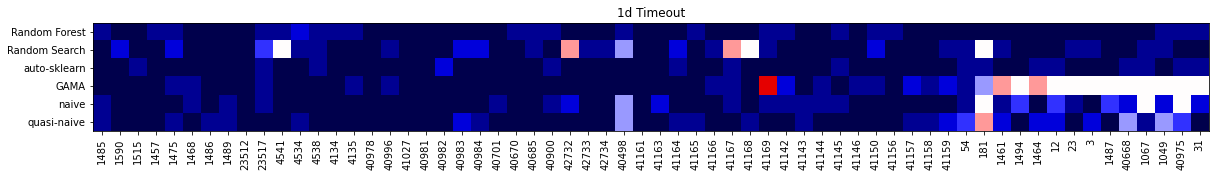

In [8]:
def plotAvailability(df):
    Z = np.zeros((len(datasets), len(OPTIMIZERS)))
    for i, openmlid in enumerate(datasets):
        for j, algo in enumerate(OPTIMIZERS):
            Z[i,j] = np.count_nonzero((df["algorithm"] == algo) & (df["openmlid"] == openmlid))
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.imshow(-Z.T, cmap="seismic", vmin = -10, vmax=0)
    ax.set_yticks(range(len(OPTIMIZERS)))
    ax.set_yticklabels([OPTIMIZER_NAMES[o] for o in OPTIMIZERS])
    ax.set_xticks(range(len(datasets)))
    ax.set_xticklabels(datasets, rotation=90)
    return ax

ax = plotAvailability(dfResults)
ax.set_title("1d Timeout")
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

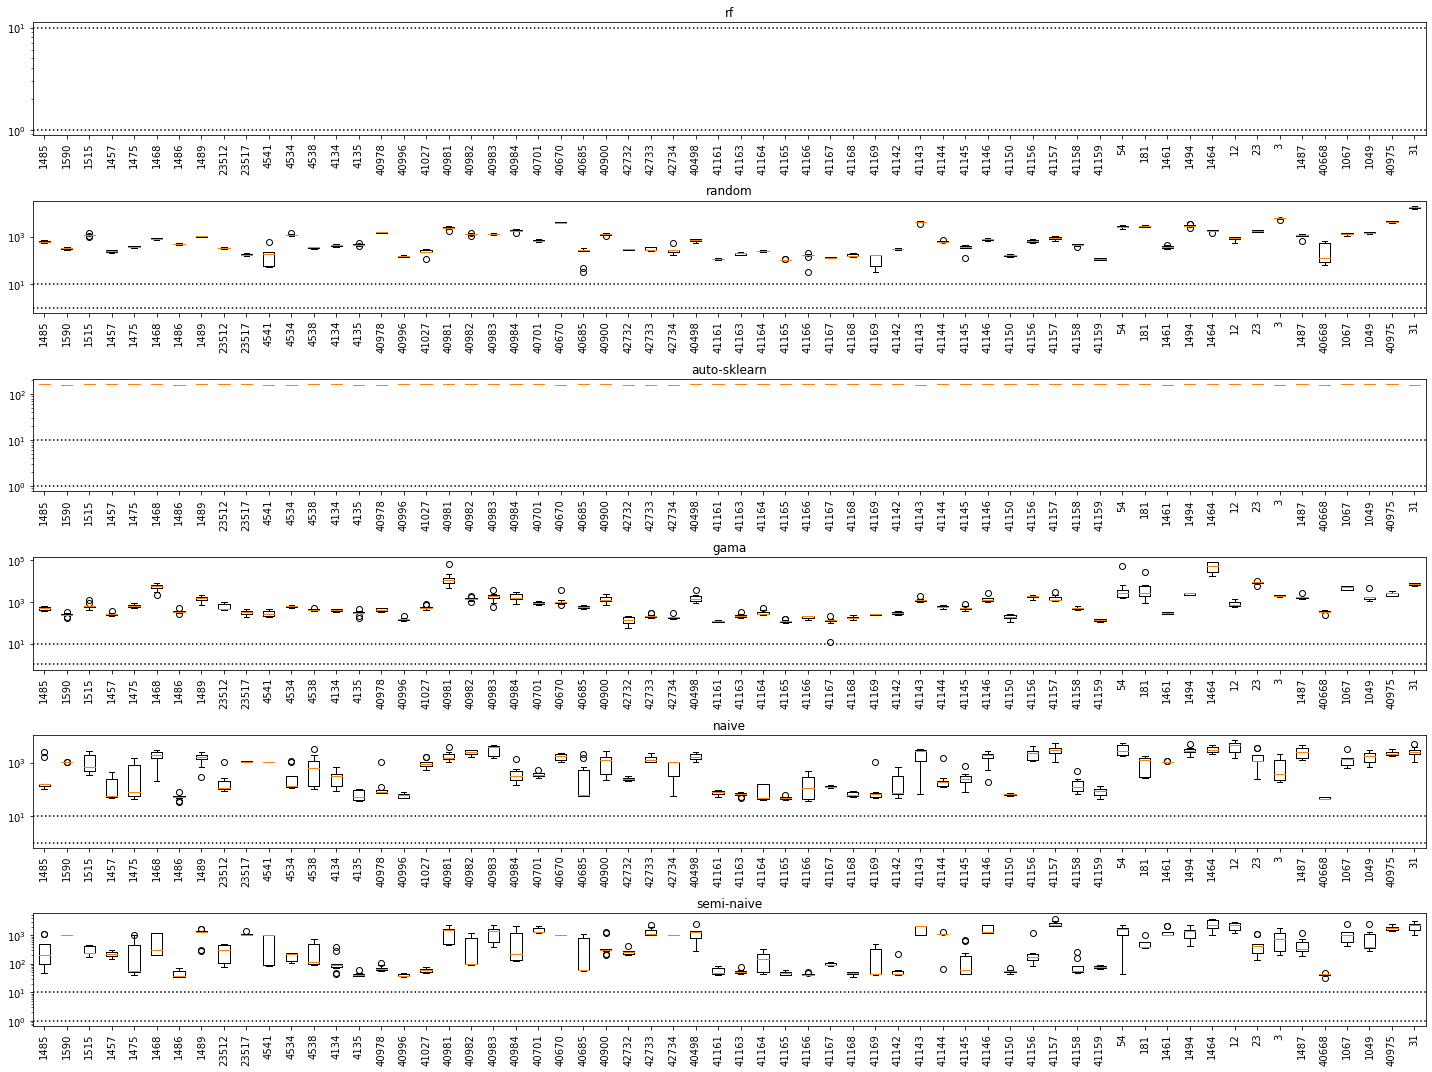

In [9]:
fig, ax = plt.subplots(len(OPTIMIZERS), 1, figsize=(20, 15))
eval_counts = {}
for i, algo in enumerate(tqdm(OPTIMIZERS)):
    dfAlgo = dfResults[dfResults["algorithm"] == algo]
    boxplot_data = []
    eval_counts[algo] = []
    for openmlid in datasets:
        dfFocus = dfAlgo[dfAlgo["openmlid"] == openmlid]
        counts = []
        for case in dfFocus["onlinedata"]:
            case_parsed = json.loads(case)
            counts.append(len(case_parsed))
        boxplot_data.append(counts)
        eval_counts[algo].append(np.mean(counts))
    ax[i].boxplot(boxplot_data)
    ax[i].set_title(algo)
    ax[i].axhline(1, linestyle="dotted", color="black")
    ax[i].axhline(10, linestyle="dotted", color="black")
    ax[i].set_yscale("log")
    ax[i].set_xticklabels(datasets, rotation=90)
fig.tight_layout()

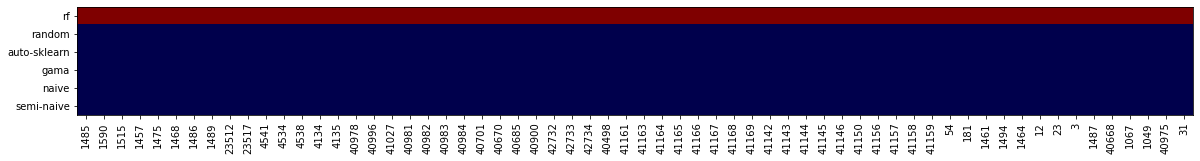

In [10]:
Z = np.zeros((len(OPTIMIZERS), len(datasets)))
for i, algo in enumerate(OPTIMIZERS):
    for j, openmlid in enumerate(datasets):
        Z[i,j] = eval_counts[algo][j]

fig, ax = plt.subplots(figsize=(20, 5))
ax.imshow(-Z, cmap="seismic", vmin=-20)
ax.set_yticks(range(len(OPTIMIZERS)))
ax.set_yticklabels(OPTIMIZERS)
ax.set_xticks(range(len(datasets)))
ax.set_xticklabels(datasets, rotation=90)
plt.show()

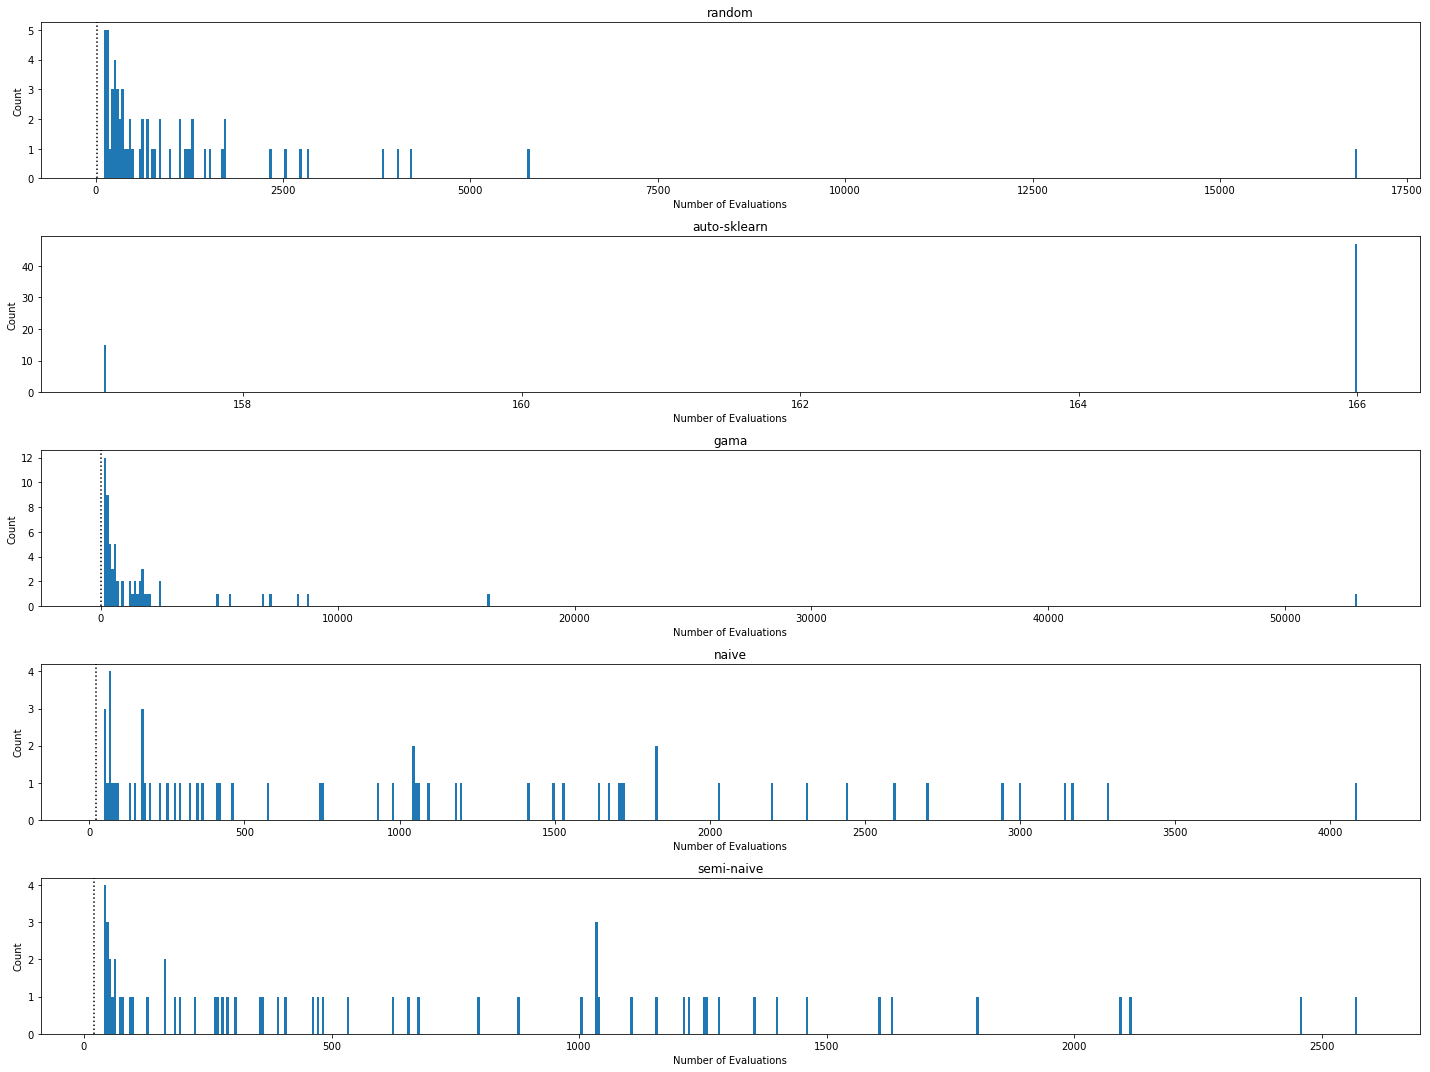

In [11]:
fig, ax = plt.subplots(len(OPTIMIZERS[1:]), 1, figsize=(20, 15))
for i, algo in enumerate(OPTIMIZERS[1:]):
    ax[i].hist(eval_counts[algo], bins=500)
    ax[i].set_title(algo)
    if algo != "auto-sklearn":
        ax[i].axvline(20, linestyle="dotted", color="black")
    ax[i].set_xlabel("Number of Evaluations")
    ax[i].set_ylabel("Count")
fig.tight_layout()

# Extract Performance Curves of the Systems

In [12]:
def get_runtime(time_start, time_end):
    timestamp_start = datetime.datetime.timestamp(datetime.datetime.strptime(time_start, "%Y-%m-%d %H:%M:%S"))
    timestamp_end = datetime.datetime.timestamp(datetime.datetime.strptime(time_end, "%Y-%m-%d %H:%M:%S"))
    return timestamp_end - timestamp_start

def get_curve_for_autosklearn(dataframe, T = None):
    cases = []
    for i, case in enumerate(dataframe.sort_values("seed")["onlinedata"].values):
        try:
            case_parsed = ast.literal_eval(case)
            timestamps = [int(t) for t in case_parsed["timestamps"]]
            scores = np.array(case_parsed["mean_test_score"]).astype(float)
            if len(timestamps) != len(scores):
                del timestamps[-1]
            exp_timestamps = dataframe[["timeout_total", "time_started", "time_end"]].values[i]
            runtime = min(exp_timestamps[0], get_runtime(exp_timestamps[1], exp_timestamps[2]))
            cases.append((timestamps, scores, runtime))
        except ValueError:
            print("Ignoring case with error")
    return get_curve_for_cases(cases, T)

def get_curve_for_naive(dataframe, T = None, receive_float = False):
    if len(dataframe) == 0:
        return {}
    algos = list(pd.unique(dataframe["algorithm"]))
    if len(algos) != 1:
        raise Exception(f"There should be exactly one algorithm in the frame. Contained algorithms: {algos}")
    algo = algos[0]
    cases = []
    for i, case in enumerate(dataframe.sort_values("seed")["onlinedata"].values):
        case_parsed = json.loads(case)
        timestamps = []
        scores = []
        time_prev = 0
        for time, pl, scores_tmp in case_parsed:
            score = scores_tmp["neg_log_loss"] if not receive_float else scores_tmp
            if not np.isnan(score):
                
                if score < 0: # adjust those scoress that were tracked negatively
                    score *= -1
                timestamps.append(time)
                scores.append(score)
            time_prev = time
        exp_timestamps = dataframe[["timeout_total", "time_started", "time_end"]].values[i]
        runtime = min(exp_timestamps[0], get_runtime(exp_timestamps[1], exp_timestamps[2]))
        cases.append((timestamps, scores, runtime))
    return get_curve_for_cases(cases, T)

def get_curve_for_rf(dataframe, T = None):
    cases = []
    for i, score in enumerate(dataframe.sort_values("seed")["metric"].values):
        try:
            scores = [score]
            exp_timestamps = dataframe[["timeout_total", "time_started", "time_end"]].values[i]
            runtime = min(exp_timestamps[0], get_runtime(exp_timestamps[1], exp_timestamps[2]))
            timestamps = [runtime]
            cases.append((timestamps, scores, runtime))
        except ValueError:
            pass
    return get_curve_for_cases(cases, T)
    
    
def get_curve_for_cases(cases, T = None):
    
    if not cases:
        return {
            "times": np.array([]),
            "values": np.array([])
        }
    
    # clean cases by removing non-monotone observations
    cleaned_cases = []
    for timestamps, scores, termination in cases:
        
        # sanity check for the case
        if len(timestamps) != len(scores):
            raise Exception("Timestamp series has length " + str(len(timestamps)) + " whereas scores has length " + str(len(scores)))
        
        # add timestamps
        scores_n = []
        timestamps_n = []
        for i, t in enumerate(timestamps):
            score = scores[i]
            if not scores_n or score < scores_n[-1]:
                timestamps_n.append(t)
                scores_n.append(score)
        cleaned_cases.append((timestamps_n, scores_n, termination))
            
    
    # get anchors for which we need to provide curve information
    anchors = set([])
    max_runtime = 0
    for timestamps, scores, termination in cleaned_cases:
        
        # sanity check for the case
        if len(timestamps) != len(scores):
            raise Exception("Timestamp series has length " + str(len(timestamps)) + " whereas scores has length " + str(len(scores)))
        
        # add timestamps
        for i, t in enumerate(timestamps):
            anchors.add(t)
        
        max_runtime = max(max_runtime, termination)
    
    # now compute all relevant metrics for each point
    times = sorted(anchors)
    if T is not None:
        times = [t for t in times if t < T]
        if times[-1] < T:
            times.append(T)
        
    curve = []
    for t in times:
        
        # get latest valid score of each case at this point
        vals = []
        for ts, scores, termination in cleaned_cases:
            mask = [v <= t for v in ts]
            if not True in mask:
                val = np.inf
            elif not False in mask:
                val = scores[-1]
            else:
                index = mask.index(False) - 1
                val = scores[index]
            vals.append(val)
        curve.append(vals)
    curve = np.array(curve)
    if np.count_nonzero(curve < 0) > 0:
        raise Exception(f"Curve has negative values: {curve}")
    
    times_recovered = sorted(list(set(times)))
    if len(times) != len(times_recovered) or any([times[i] != t for i, t in enumerate(times_recovered)]):
        raise Exception(f"Times for algo {algo} on dataset {openmlid} are ill formated: {times}")
    
    return {
        "times": np.array(times),
        "values": curve
    }

def get_performance_curves(df, timeout):
    performance_curves = {}
    for openmlid, dfDataset in tqdm(df[df["timeout_total"] == timeout].groupby("openmlid")):
        curves = {}
        curves["auto-sklearn"] = get_curve_for_autosklearn(dfDataset[(dfDataset["algorithm"] == "auto-sklearn")], T=timeout)
        curves["semi-naive"] = get_curve_for_naive(dfDataset[(dfDataset["algorithm"] == 'semi-naive')], T=timeout)
        curves["naive"] = get_curve_for_naive(dfDataset[(dfDataset["algorithm"] == 'naive')], T=timeout)
        curves["gama"] = get_curve_for_naive(dfDataset[(dfDataset["algorithm"] == 'gama')], T=timeout, receive_float=True)
        curves["rf"] = get_curve_for_rf(dfDataset[(dfDataset["algorithm"] == 'rf')], T=timeout)
        curves["random"] = get_curve_for_naive(dfDataset[(dfDataset["algorithm"] == 'random')], T=timeout)
        performance_curves[openmlid] = curves
    return performance_curves

In [13]:
performance_curves_1d = get_performance_curves(dfResults, 85000)

  0%|          | 0/62 [00:00<?, ?it/s]

# Write Files with Performance Curves and Final Results

In [14]:
with open('performancecurves.pickle', 'wb') as f:
    pickle.dump(performance_curves_1d, f, protocol=0)

In [15]:
dfResults.rename(columns={"timeout_total": "timeout"})[["timeout", "openmlid", "seed", "algorithm", "metric"]].to_csv("results_final.csv", index=False)